In [146]:
# Utilities
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import getpass
import math

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

### Utils functions

In [ ]:
def polygon_to_bbox(geom):
    """
    Converte un GeoJSON Polygon in una bounding box (min_lon, min_lat, max_lon, max_lat).
    
    Parameters:
    - geom (dict): dizionario GeoJSON contenente un poligono
    
    Returns:
    - tuple: bounding box (min_lon, min_lat, max_lon, max_lat)
    """
    if geom["type"] != "Polygon":
        raise ValueError("Solo poligoni supportati.")

    coords = geom["coordinates"][0]  # lista di coordinate [lon, lat]

    lons = [point[0] for point in coords]
    lats = [point[1] for point in coords]

    min_lon = min(lons)
    max_lon = max(lons)
    min_lat = min(lats)
    max_lat = max(lats)

    return (min_lon, min_lat, max_lon, max_lat)

In [ ]:
def create_microareas_grid(bbox, max_area_km2):
    """
    Divide una bounding box in microaree rettangolari di dimensione massima circa max_area_km2.

    Args:
        bbox (tuple): (min_lon, min_lat, max_lon, max_lat)
        max_area_km2 (float): area massima per microarea in km².

    Returns:
        dict: dizionario con chiavi 'micro_1', 'micro_2', ..., e valori bbox (min_lon, min_lat, max_lon, max_lat)
    """
    min_lon, min_lat, max_lon, max_lat = bbox

    # Calcolo latitudine media per correggere la lunghezza dei gradi di longitudine
    mean_lat = (min_lat + max_lat) / 2
    km_per_deg_lat = 111  # circa costante
    km_per_deg_lon = 111 * math.cos(math.radians(mean_lat))

    # Dimensioni della bounding box in km
    width_km = (max_lon - min_lon) * km_per_deg_lon
    height_km = (max_lat - min_lat) * km_per_deg_lat

    total_area_km2 = width_km * height_km

    # Numero stimato di microaree
    num_microareas = math.ceil(total_area_km2 / max_area_km2)

    # Calcolo righe e colonne approssimative
    n_cols = math.ceil(math.sqrt(num_microareas * (width_km / height_km)))
    n_rows = math.ceil(num_microareas / n_cols)

    lon_step = (max_lon - min_lon) / n_cols
    lat_step = (max_lat - min_lat) / n_rows

    microareas = {}
    count = 1

    for i in range(n_rows):
        for j in range(n_cols):
            cell_min_lon = min_lon + j * lon_step
            cell_max_lon = cell_min_lon + lon_step
            cell_min_lat = min_lat + i * lat_step
            cell_max_lat = cell_min_lat + lat_step

            microareas[f"micro_{count}"] = (
                cell_min_lon,
                cell_min_lat,
                cell_max_lon,
                cell_max_lat
            )
            count += 1

    return microareas

In [150]:
def plot_image(image, factor=3.5/255, clip_range=(0, 1)):
    """
    Plots an RGB image after rescaling and clipping.

    Parameters:
    - image: np.ndarray of shape (H, W, 3)
    - factor: multiplicative rescaling factor applied to the image
    - clip_range: tuple (min_value, max_value) to clip the image values
    """
    # Apply rescaling factor
    image = image * factor

    # Clip the values to the specified range
    image = np.clip(image, clip_range[0], clip_range[1])

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


### Catalog and Image processing

In [ ]:
# Client configuration
config = SHConfig()

MacroGrid Example

In [ ]:
macro_geom = {"type":"Polygon","coordinates":[[[-124.244385,41.779505],[-121.129761,41.779505],[-121.05835,39.60992],[-124.442139,39.614152],[-124.464111,41.779505],[-124.244385,41.779505]]]}

In [ ]:
macro_bbox = polygon_to_bbox(macro_geom)
microareas_bbox = create_microareas_grid(macro_bbox, 600)
microarea_example_bbox = microareas_bbox['micro_55']

In [ ]:
aoi_coords_wgs84 = list()
for coord in microarea_example_bbox:
    aoi_coords_wgs84.append(coord)

In [ ]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Catalog processing

In [ ]:
catalog = SentinelHubCatalog(config=config)

In [ ]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2024-04-01", "2024-04-20"

In [ ]:
search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Image Processing

In [142]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2024-05-01", "2024-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

The method get_data() will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [143]:
true_color_imgs = request_true_color.get_data()

In [144]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (2419, 2391, 3)


Image type: uint8


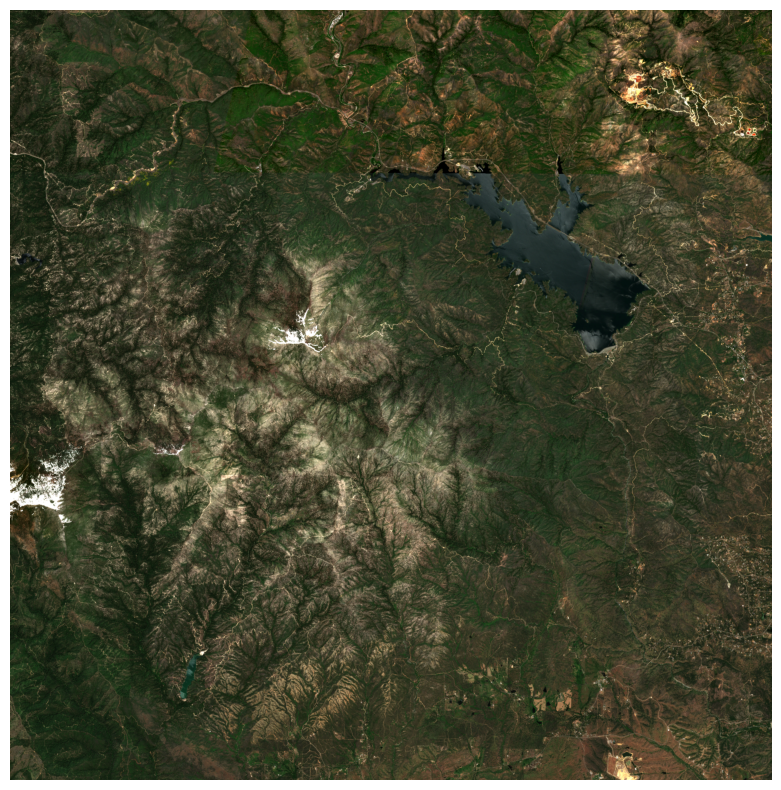

In [151]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))